# **Fingerprint thinning**

In [1]:
from KMM import KMM
from morphology import morphology_thinning
import numpy as np
from PIL import Image
import cv2
from IPython.display import display
import matplotlib.pyplot as plt

In [2]:
def perform_thinning(
    path: str, 
    show_by_iterations: bool = False, 
    algorithm: str = 'KMM',
    show: bool = True,
    correct_original: bool = True,
    correct_thinning: bool = True
    ) -> np.ndarray:
    
    algs = {
        'KMM': KMM,
        'morphology': morphology_thinning
    }
    
    if algorithm not in algs:
        raise ValueError(f"Unknown algorithm: {algorithm}. Available algorithms: {list(algs.keys())}")

    alg = algs[algorithm]
    farray = read_bmp(path)
    
    if show:
        img = Image.fromarray(farray)
        print("Original Image")
        display(img)
    
    if correct_original:
        farray = correct_orig(farray)
        if show:
            img = Image.fromarray(farray)
            print("\nCorrected Original Image")
            display(img)
    
    skeleton = alg(farray, show=show_by_iterations)

    if show:
        img_skeleton = skeleton.copy()
        img_skeleton[skeleton == 0] = 255
        img_skeleton[skeleton == 1] = 0
        img_skeleton = img_skeleton.astype(np.uint8)
        img = Image.fromarray(img_skeleton)
        print("\nThinned Image")
        display(img)  
        
    if correct_thinning:
        skeleton = correct(skeleton)    
        img_skeleton = skeleton.copy()
        img_skeleton[skeleton == 0] = 255
        img_skeleton[skeleton == 1] = 0


        img_skeleton = img_skeleton.astype(np.uint8)
        img = Image.fromarray(img_skeleton)
        print("\nThinned Image after Morphological Correction")
        display(img) 
      
    return skeleton

    
def read_bmp(path: str) -> np.ndarray:
    image = Image.open(path)
    image_np = np.array(image)
    _, farray = cv2.threshold(image_np, 127, 255, cv2.THRESH_BINARY)
    if farray.ndim == 3:
        farray = farray[:, :, 0]
    return farray


def correct(skeleton: np.ndarray) -> np.ndarray:
    skeleton = (skeleton > 0).astype(np.uint8)
    out = skeleton.copy()
    
    kernel_h = np.ones((1, 3), np.uint8)  
    kernel_v = np.ones((3, 1), np.uint8) 
    
    dilated_h = cv2.dilate(out, kernel_h, iterations=1)
    dilated_v = cv2.dilate(out, kernel_v, iterations=1)
    dilated = cv2.bitwise_or(dilated_h, dilated_v)

    kernel = np.ones((2, 2), np.uint8)
    eroded = cv2.erode(dilated, kernel, iterations=1)
    
    k = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 1))
    out = cv2.morphologyEx(eroded, cv2.MORPH_ERODE, k)
    
    k = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 2))
    out = cv2.morphologyEx(out, cv2.MORPH_DILATE, k)
    k = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 1))
    out = cv2.morphologyEx(out, cv2.MORPH_DILATE, k)
    
    k = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 2))
    out = cv2.morphologyEx(out, cv2.MORPH_ERODE, k)
    k = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 1))
    out = cv2.morphologyEx(out, cv2.MORPH_ERODE, k)
    
    return out


def correct_orig(farray: np.ndarray) -> np.ndarray:
    img = farray.copy()
    
    if np.max(img) == 1:
        binary_input = True
        img = (img * 255).astype(np.uint8)
    else:
        binary_input = False
        img = img.astype(np.uint8)
    
    original = img.copy()
    
    kernel = np.ones((2, 2), np.uint8)
    gradient = cv2.morphologyEx(original, cv2.MORPH_GRADIENT, kernel)
    
    dilated = cv2.dilate(original, kernel, iterations=1)
    
    result = cv2.bitwise_or(original, dilated)
    
    kernel_noise = np.ones((2, 2), np.uint8)
    temp = cv2.morphologyEx(result, cv2.MORPH_OPEN, kernel_noise, iterations=1)
    
    result = cv2.bitwise_or(temp, original)
    
    if binary_input:
        result = (result > 0).astype(np.uint8)
    
    return result

# **Example**

In [3]:
#Najlepsze ustawienia:
# KMM - True, False
# morphology - False, True

Original Image


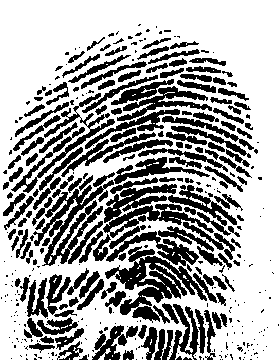


Corrected Original Image


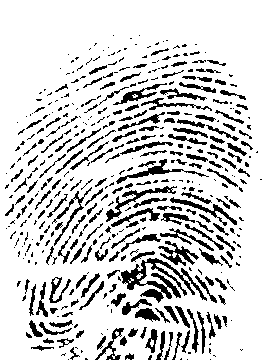


Thinned Image


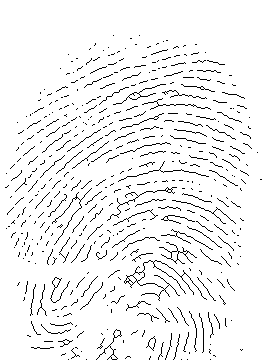

In [ ]:
tester = 'test_data/tester.bmp'
skeleton = perform_thinning(path=tester, 
                            show_by_iterations=False,
                            show=True, 
                            algorithm='KMM',
                            correct_original=True,
                            correct_thinning=False)

# **Minutiae detection**

In [5]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def detect_minutiae(skel: np.ndarray, show: bool = True) -> dict:
    assert skel.dtype == np.uint8 and set(np.unique(skel)).issubset({0,1})
    h, w = skel.shape
    padded = np.pad(skel, ((1, 1), (1, 1)), mode='constant', constant_values=0)
    minutiae = {}
    for i in range(1, h + 1):
        for j in range(1, w + 1):
            if padded[i, j] == 1:
                neighborhood = padded[i - 1:i + 2, j - 1:j + 2]
                sum = np.sum(neighborhood)
                if sum == 2:
                    add_ending(i, j, padded, minutiae)
                elif sum == 4:
                    add_bifurcation(i, j, padded, minutiae)

    minutiae = remove_similar_direction_minutiae(minutiae)
    minutiae = filter_close_minutiae(minutiae)
    
    if show:
        show_minutiae(skel, minutiae)
       
    return minutiae

def add_bifurcation(i: int, j: int, padded: np.ndarray, minutiae: dict) -> None:
    neighbors = [(0, 1), (-1, 1), (-1, 0), (-1, -1), (0, -1), (1, -1), (1, 0), (1, 1)]
    count = 1
    ones = []
    neighborhood = padded[i - 1:i + 2, j - 1:j + 2]
    for x_neighbor, y_neighbor in neighbors:
        if padded[i + x_neighbor, j + y_neighbor] == 1:
            ones.append(count)
            if x_neighbor == 1 and y_neighbor == 1:
                ones.append(0)
        count += 1
   
    mod_diffs = np.abs(np.diff(ones))
    last_first_diff = np.abs(ones[-1] - ones[0])
    full_diffs = np.append(mod_diffs, last_first_diff)
    if 1 in full_diffs:
        return
    if ones == [1, 4, 7]:
        split_index = 2  
    else:
        split_index = np.where(full_diffs == 2)[0][0]
    direction = split_index
    direction_angle = ones[direction]
    angle = (45 * direction_angle) % 360
    minutiae[(i, j)] = {
        'type': 'bifurcation',
        'direction': angle,
        'quality': 1.0 
    }

def add_ending(i: int, j: int, padded: np.ndarray, minutiae: dict) -> None:
    neighbors = [(0, 1), (-1, 1), (-1, 0), (-1, -1), (0, -1), (1, -1), (1, 0), (1, 1)]
    neighborhood = padded[i - 1:i + 2, j - 1:j + 2]
    counter = 0
    for x_neighbor, y_neighbor in neighbors:
        if padded[i + x_neighbor, j + y_neighbor] == 1:
            angle = (180 + 45 * counter) % 360
            break
        counter += 1
    minutiae[(i, j)] = {
        'type': 'ending',
        'direction': angle,
        'quality': 1.0  
    }

def remove_similar_direction_minutiae(minutiae, angle_threshold=20, distance_threshold=15):

    to_remove = set()
    
    positions = list(minutiae.keys())

    for i in range(len(positions)):
        for j in range(i+1, len(positions)):
            pos1, pos2 = positions[i], positions[j]
            
            if pos1 in to_remove or pos2 in to_remove:
                continue
            
            i1, j1 = pos1
            i2, j2 = pos2
            distance = np.sqrt((i1 - i2)**2 + (j1 - j2)**2)
            
            if distance <= distance_threshold:
                dir1 = minutiae[pos1].get('direction', 0)
                dir2 = minutiae[pos2].get('direction', 0)
                
                angle_diff = abs(dir1 - dir2)
                angle_diff = min(angle_diff, 360 - angle_diff)
                
                if angle_diff <= angle_threshold:
                    quality1 = minutiae[pos1].get('quality', 0)
                    quality2 = minutiae[pos2].get('quality', 0)
                    
                    if quality1 >= quality2:
                        to_remove.add(pos2)
                    else:
                        to_remove.add(pos1)

    filtered_minutiae = {pos: data for pos, data in minutiae.items() if pos not in to_remove}
    
    return filtered_minutiae

def show_minutiae(skel: np.ndarray, minutiae: dict) -> None:
    h, w = skel.shape
    base = np.full((h, w, 3), 255, np.uint8)  
    base[skel == 1] = (0, 0, 0)  
    vis = base.copy()
    for (i, j), data in minutiae.items():
        typ = data['type']
        angle = data['direction']
        if typ == 'ending':
            color = (0, 0, 255)  
        elif typ == 'bifurcation':
            color = (255, 0, 0)  
        cv2.circle(vis, (j, i), 2, color, thickness=-1)
        length = 8
        dx = int(length * np.cos(np.radians(angle)))
        dy = int(-length * np.sin(np.radians(angle)))  
        end_point = (j + dx, i + dy)
        cv2.arrowedLine(vis, (j, i), end_point, color, thickness=1, tipLength=0.3)
    plt.figure(figsize=(10, 10))
    plt.imshow(vis[..., ::-1])  
    plt.axis('off')
    plt.show()

def filter_close_minutiae(minutiae: dict, min_distance: float = 10.0) -> dict:
    if len(minutiae) <= 1:
        return minutiae
    
    sorted_minutiae = sorted(
        minutiae.items(), 
        key=lambda x: x[1].get('quality', 0.0), 
        reverse=True
    )
    
    filtered_minutiae = {}
    for (i, j), data in sorted_minutiae:
        too_close = False
        for (fi, fj) in filtered_minutiae.keys():
            dist = np.sqrt((i - fi)**2 + (j - fj)**2)
            if dist < min_distance:
                too_close = True
                break
        
        if not too_close:
            filtered_minutiae[(i, j)] = data
    
    return filtered_minutiae


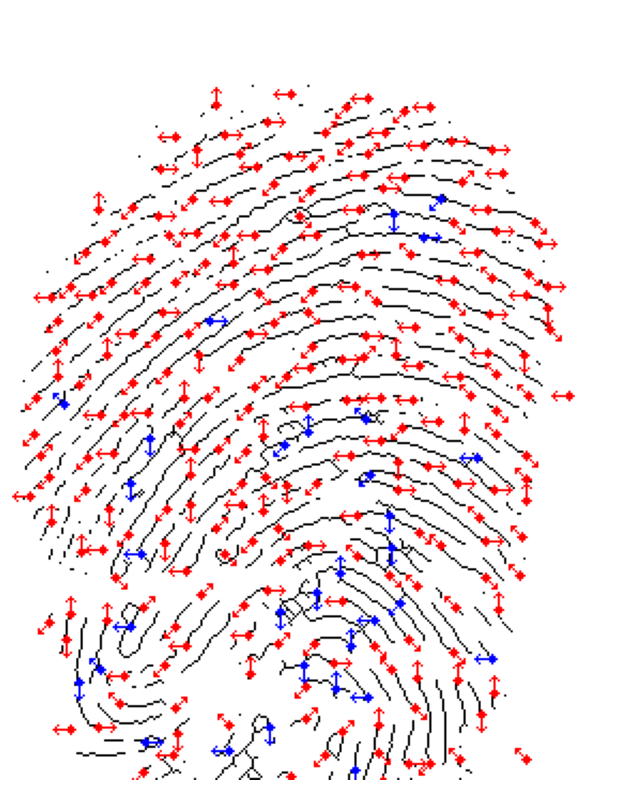

{(39, 131): {'type': 'ending', 'direction': 180, 'quality': 1.0},
 (41, 167): {'type': 'ending', 'direction': 180, 'quality': 1.0},
 (44, 96): {'type': 'ending', 'direction': 90, 'quality': 1.0},
 (45, 157): {'type': 'ending', 'direction': 225, 'quality': 1.0},
 (45, 196): {'type': 'ending', 'direction': 180, 'quality': 1.0},
 (47, 184): {'type': 'ending', 'direction': 225, 'quality': 1.0},
 (52, 120): {'type': 'ending', 'direction': 0, 'quality': 1.0},
 (57, 147): {'type': 'ending', 'direction': 45, 'quality': 1.0},
 (57, 175): {'type': 'ending', 'direction': 180, 'quality': 1.0},
 (58, 100): {'type': 'ending', 'direction': 0, 'quality': 1.0},
 (59, 77): {'type': 'ending', 'direction': 180, 'quality': 1.0},
 (61, 206): {'type': 'ending', 'direction': 0, 'quality': 1.0},
 (62, 158): {'type': 'ending', 'direction': 225, 'quality': 1.0},
 (63, 193): {'type': 'ending', 'direction': 180, 'quality': 1.0},
 (65, 87): {'type': 'ending', 'direction': 270, 'quality': 1.0},
 (65, 225): {'type': 

In [6]:
detect_minutiae(skeleton, show=True)